# becquerel fitting example

In [1]:
import becquerel as bq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

np.random.seed(0)

Read an example spectrum into a Spectrum object

In [2]:
spec1 = bq.Spectrum.from_file('../tests/samples/digibase_5min_30_1.spe')

SpeFile: Reading file ../tests/samples/digibase_5min_30_1.spe


Plot the entire spectrum and the ROI we want to fit

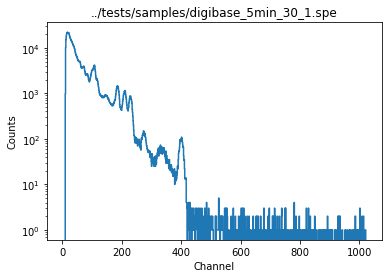

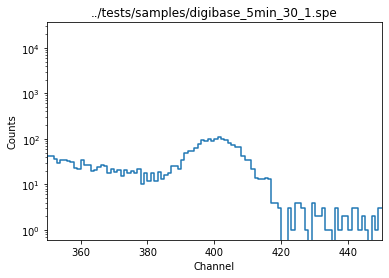

In [3]:
spec1.plot(yscale='log')
plt.show()

spec1.plot(yscale='log', xlim=(350, 450))
plt.show()

Looks like a gauss peak shape plus an exponential background model will be appropriate

In [4]:
model = (bq.fitting.GaussModel(prefix='gauss0_') + bq.fitting.ExpModel(prefix='exp_'))

Pass our model and data to a Fitter object, then perform the fit

In [5]:
fitter = bq.Fitter(
    model,
    x=spec1.channels,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450)
)

fitter.fit()

`custom_plot()` lets us see the fit result and diagnostics simultaneously

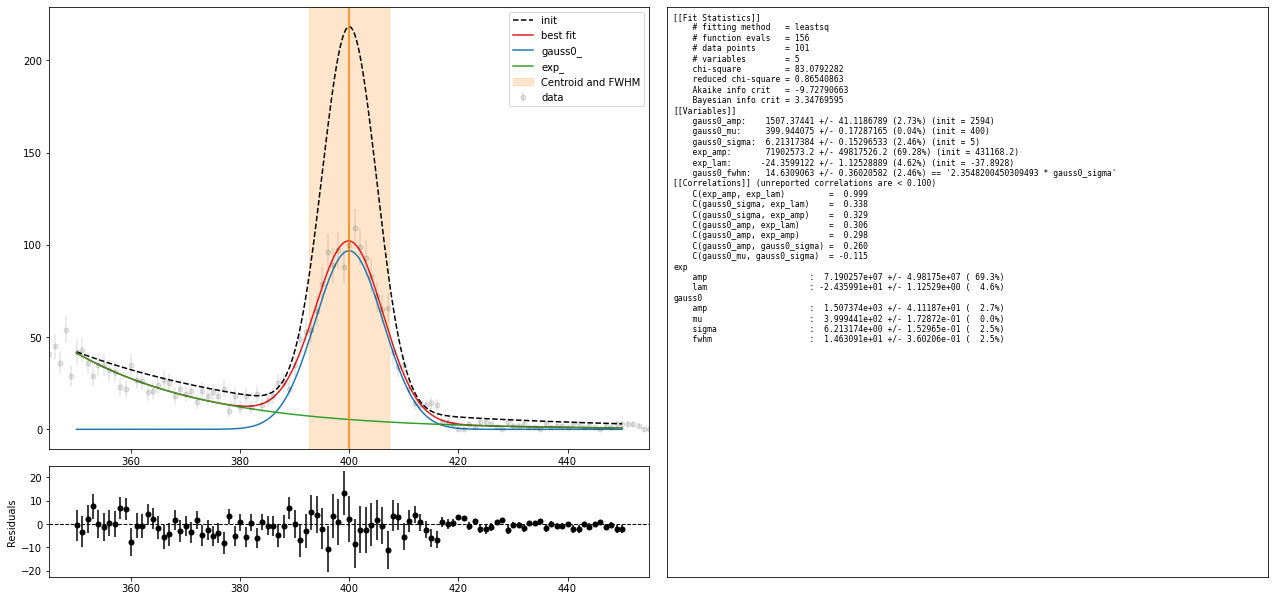

In [6]:
fitter.custom_plot()
plt.show()

Alternatively, we can pass a list of string model names to the Fitter. At the same time, let's try a linear background model instead of the exponential.

In [7]:
fitter = bq.Fitter(
    ['gauss', 'line'],
    y=spec1.counts_vals,
    x=spec1.channels,
    y_unc=spec1.counts_uncs,
    roi=(350, 450)
)
fitter.fit()

We can also specify that we want to plot normalized instead of absolute residuals

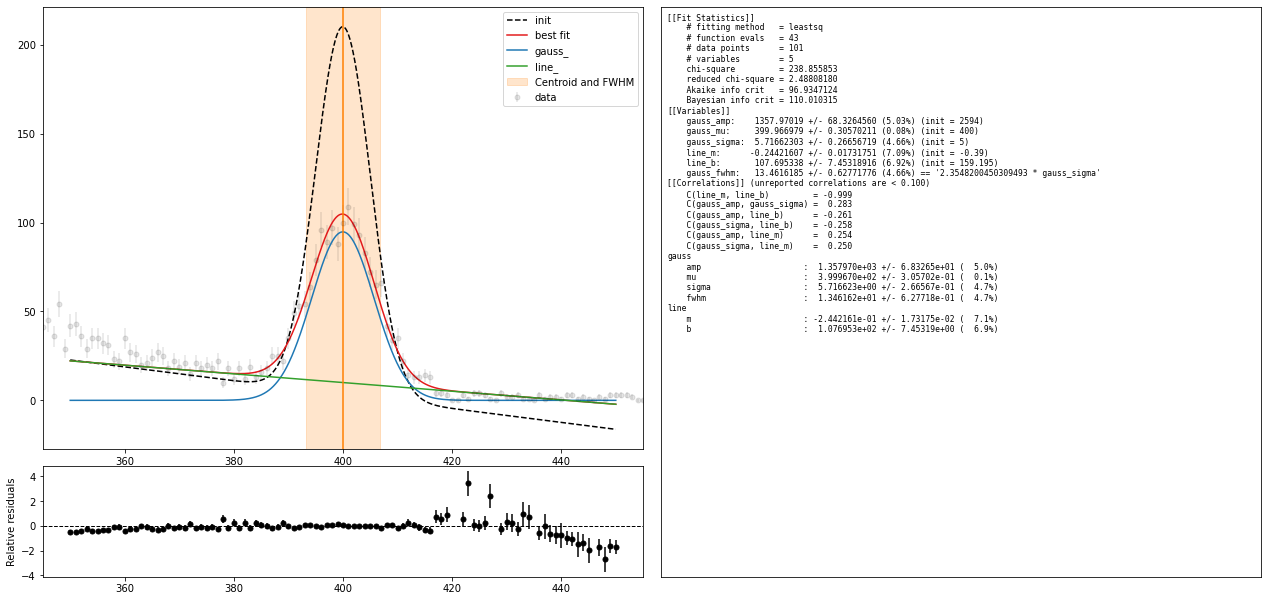

In [8]:
fitter.custom_plot(norm_residuals=True)
plt.show()

The normalized residuals help show that the linear background model performs poorly on the high-E side of the peak.